1. Exploration

In [1]:
import pandas as pd
import yfinance as yf
import yahoo_fin.stock_info as si
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt
import seaborn as sns


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


We can take as an example APPLE:

In [2]:
nas_aapl= get_data("aapl", start_date="11/30/2019", end_date="11/30/2024", index_as_date = False, interval="1d") #différents interval (1m to 3months)
nas_aapl

,date,open,high,low,close,adjclose,volume,ticker
0,2019-12-02,66.817497,67.062500,65.862503,66.040001,64.024620,94487200,AAPL
1,2019-12-03,64.577499,64.882500,64.072502,64.862503,62.883057,114430400,AAPL
2,2019-12-04,65.267502,65.827499,65.169998,65.434998,63.438076,67181600,AAPL
3,2019-12-05,65.947502,66.472504,65.682503,66.394997,64.368790,74424400,AAPL
4,2019-12-06,66.870003,67.750000,66.824997,67.677498,65.612137,106075600,AAPL
...,...,...,...,...,...,...,...,...
1253,2024-11-22,228.059998,230.720001,228.059998,229.869995,229.869995,38168300,AAPL
1254,2024-11-25,231.460007,233.250000,229.740005,232.869995,232.869995,90152800,AAPL
1255,2024-11-26,233.330002,235.570007,233.330002,235.059998,235.059998,45986200,AAPL
1256,2024-11-27,234.470001,235.690002,233.809998,234.929993,234.929993,33498400,AAPL


In [3]:
print(nas_aapl.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1258 non-null   datetime64[ns]
 1   open      1258 non-null   float64       
 2   high      1258 non-null   float64       
 3   low       1258 non-null   float64       
 4   close     1258 non-null   float64       
 5   adjclose  1258 non-null   float64       
 6   volume    1258 non-null   int64         
 7   ticker    1258 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 78.8+ KB
None


In [4]:
nas_aapl.head() #on peut rajouter une colonne delta qui fait high - low pour voir de combien ça varie par jour

,date,open,high,low,close,adjclose,volume,ticker
0,2019-12-02,66.817497,67.062500,65.862503,66.040001,64.024620,94487200,AAPL
1,2019-12-03,64.577499,64.882500,64.072502,64.862503,62.883057,114430400,AAPL
2,2019-12-04,65.267502,65.827499,65.169998,65.434998,63.438076,67181600,AAPL
3,2019-12-05,65.947502,66.472504,65.682503,66.394997,64.368790,74424400,AAPL
4,2019-12-06,66.870003,67.750000,66.824997,67.677498,65.612137,106075600,AAPL


In [5]:
nas_aapl["volume"].describe()

count    1.258000e+03
mean     9.169537e+07
std      5.323647e+07
min      2.404830e+07
25%      5.641520e+07
50%      7.732030e+07
75%      1.089459e+08
max      4.265100e+08
Name: volume, dtype: float64

2. Pre-processing

We can start by checking how much tickers there are in the NASDAQ stocks market:

In [6]:
nas_list=si.tickers_nasdaq()
print("Tickers in Nasdaq:", len(nas_list))
print(nas_list[0:15])
nasdaq_list=nas_list[0:15]

Tickers in Nasdaq: 4798
['AACG', 'AADI', 'AADR', 'AAL', 'AAME', 'AAOI', 'AAON', 'AAPB', 'AAPD', 'AAPL', 'AAPU', 'AAXJ', 'ABAT', 'ABCL', 'ABCS']


Informations about the data:

We put all the data about the charts in a dictionnary:

In [7]:
#ticker_list = ["amzn", "aapl", "ba"]
dict_data_tickers = {}
for ticker in nasdaq_list:
    dict_data_tickers[ticker] = get_data(ticker, start_date="11/30/2014", end_date="11/30/2024", index_as_date = True, interval="1d")

Example of how to access it:

In [8]:
print(dict_data_tickers[list(dict_data_tickers)[0]])

            open  high   low  close  adjclose  volume ticker
2014-12-01  3.95  3.98  3.87   3.87  0.371163    6000   AACG
2014-12-02  3.72  3.72  3.72   3.72  0.356777     300   AACG
2014-12-03  3.70  3.85  3.51   3.51  0.336637   12800   AACG
2014-12-04  3.51  3.61  3.26   3.30  0.316496   22100   AACG
2014-12-05  3.29  3.45  3.11   3.11  0.298274   15400   AACG
...          ...   ...   ...    ...       ...     ...    ...
2024-11-22  1.00  1.02  0.98   1.02  1.020000   51000   AACG
2024-11-25  1.00  1.02  0.97   1.02  1.020000   56400   AACG
2024-11-26  1.02  1.02  0.98   1.02  1.020000   15000   AACG
2024-11-27  1.00  1.01  0.94   1.00  1.000000   94100   AACG
2024-11-29  0.96  1.01  0.96   1.00  1.000000   24400   AACG

[2517 rows x 7 columns]


Dictionary of volumes per charts:

In [9]:
dict_volume={}
for ticker in dict_data_tickers:
    dict_volume[ticker]=dict_data_tickers[ticker]["volume"].sum()
volDF=pd.DataFrame.from_dict(dict_volume,orient="index",columns=["Volume"])
print(volDF)

            Volume
AACG     740123200
AADI     237083058
AADR      25517100
AAL    61030886200
AAME     188959800
AAOI    2942353800
AAON     769796100
AAPB      37760700
AAPD     130427000
AAPL  297906658200
AAPU     178352300
AAXJ    2735189200
ABAT     408914717
ABCL    1898549200
ABCS        905900


3. Analysis and visualizations

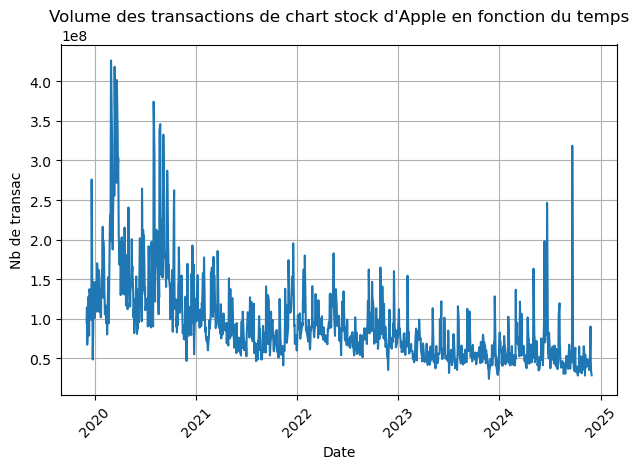

In [10]:
plt.figure()
sns.lineplot(data=nas_aapl, x="date", y="volume", marker="")
plt.title("Volume des transactions de chart stock d'Apple en fonction du temps")
plt.xlabel("Date")
plt.ylabel("Nb de transac")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

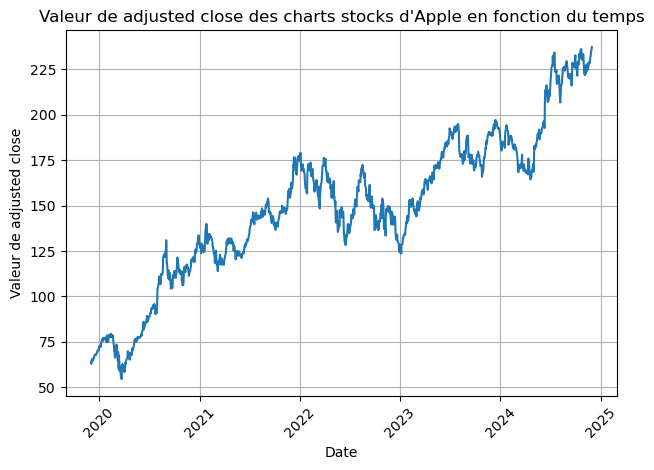

In [25]:
plt.figure()
sns.lineplot(data=nas_aapl, x="date", y="adjclose", marker="")
plt.title("Valeur de adjusted close des charts stocks d'Apple en fonction du temps")
plt.xlabel("Date")
plt.ylabel("Valeur de adjusted close")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Highest and lowest number of volume and what chart it's from:

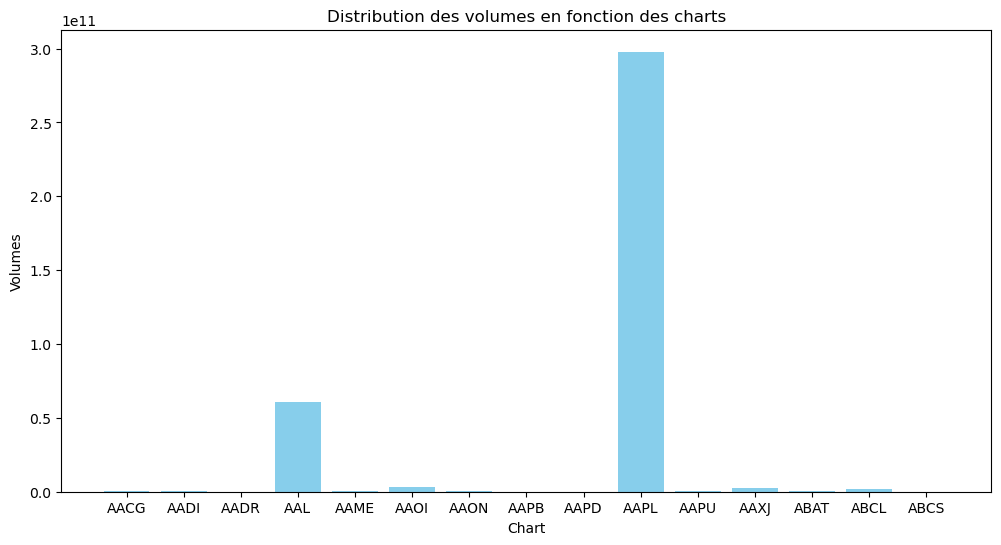

The stock chart with the biggest volume is AAPL with 297906658200.
The stock chart with the lowest volume is ABCS with 905900.


In [42]:
plt.figure(figsize=(12, 6))
plt.bar(volDF.index, volDF["Volume"], color="skyblue")
plt.title("Distribution des volumes en fonction des charts")
plt.xlabel("Chart")
plt.ylabel("Volumes")
plt.show()

print(f"The stock chart with the biggest volume is {volDF[volDF["Volume"]==volDF["Volume"].max()].index[0]} with {volDF["Volume"].max()}.")
print(f"The stock chart with the lowest volume is {volDF[volDF["Volume"]==volDF["Volume"].min()].index[0]} with {volDF["Volume"].min()}.")